In [ ]:
!pip install pyxdf
!pip install mne
!pip install pandas
!pip install --upgrade jupyterlab ipympl ipywidgets

In [ ]:
import sys

print(sys.version)

In [ ]:
import pyxdf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import mne
import pandas as pd
import os

In [92]:
csv_data = pd.read_csv('data/bundle_pricing_20260110_085948.csv', skiprows=1, skipfooter=6)
csv_data

/var/folders/g2/378vjvgj0vq1r9_l6pb_nbz00000gn/T/ipykernel_16306/3687793333.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  csv_data = pd.read_csv('data/bundle_pricing_20260110_085948.csv', skiprows=1, skipfooter=6)


,timestamp_iso,participant_id,age,response_group,trial_index,block,bundle_id,focal_product,tiein_product,condition,focal_price,tiein_price,total_price,allocation_per_trial,response_key,response,rt_ms,valid_response,is_selected_bundle,bundles_bought_cumulative
0,2026-01-10T09:00:32.793,0,26,A,0,1,45,Doorbell Camera,Chime Unit,NP,20.0,4.0,24.0,70.0,1.0,BUY,1286.14,1,0,1
1,2026-01-10T09:00:40.402,0,26,A,1,1,3,Camera,Memory Card,ZP,28.8,0.0,28.8,70.0,1.0,BUY,3135.96,1,0,2
2,2026-01-10T09:00:47.911,0,26,A,2,1,18,Coffee Maker,Coffee Filters,NP,16.0,3.2,19.2,70.0,3.0,NOBUY,1452.70,1,0,2
3,2026-01-10T09:00:55.524,0,26,A,3,1,40,External SSD,Carrying Case,NP,20.0,2.4,22.4,70.0,3.0,NOBUY,1612.21,1,0,2
4,2026-01-10T09:01:02.982,0,26,A,4,1,6,Gaming Console,Extra Controller,ZP,44.0,0.0,44.0,70.0,1.0,BUY,809.81,1,1,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
130,2026-01-10T09:17:03.862,0,26,A,130,3,16,Electric Toothbrush,Brush Heads,NP,8.0,2.4,10.4,70.0,NaN,NaN,NaN,0,0,11
131,2026-01-10T09:17:11.455,0,26,A,131,3,38,Printer,Ink Cartridge,NP,22.4,6.4,28.8,70.0,NaN,NaN,NaN,0,0,11
132,2026-01-10T09:17:18.965,0,26,A,132,3,34,Mouse,Mouse Pad,NP,9.6,1.6,11.2,70.0,NaN,NaN,NaN,0,0,11
133,2026-01-10T09:17:26.460,0,26,A,133,3,44,Security Camera,SD Card,LP,25.6,0.1,25.7,70.0,NaN,NaN,NaN,0,0,11


In [ ]:
zp_idx = csv_data[csv_data['condition'] == 'ZP'].index.values
np_idx = csv_data[csv_data['condition'] == 'NP'].index.values
lp_idx = csv_data[csv_data['condition'] == 'LP'].index.values
zp_idx, np_idx, lp_idx

In [ ]:
xdf_path = './data/bundles_test.xdf'
xdf_data = pyxdf.load_xdf(xdf_path)[0]
markers = xdf_data[0]
eeg = xdf_data[1]

In [ ]:
# LSL Markers
MARKER_FIXATION = 10
MARKER_BUNDLE_PREVIEW = 20
MARKER_BUNDLE_PRICE_NP = 31
MARKER_BUNDLE_PRICE_LP = 32
MARKER_BUNDLE_PRICE_ZP = 33
MARKER_RESPONSE_BUY = 41
MARKER_RESPONSE_NOBUY = 42
MARKER_NO_RESPONSE = 50

In [ ]:
# Read marker data
marker_time = markers['time_stamps']
time_offset = marker_time[0]
marker_time = marker_time - time_offset
marker_data = [x[0] for x in markers['time_series']]

In [ ]:
CONST_OFFSET = 0.073  # Delay measured with photodiode that day

In [ ]:
eeg_time = eeg['time_stamps']
eeg_time = eeg_time - time_offset - CONST_OFFSET
eeg_data = eeg['time_series'][:, :8]

In [95]:
# Create raw data
info = mne.create_info(ch_names=['Fz', 'C3', 'Cz', 'C4', 'Pz', 'PO7', 'Oz', 'PO8'], ch_types=['eeg'] * 8,
                       sfreq=250)
raw = mne.io.RawArray([1e-6 * eeg_data[:, i] for i in range(8)], info)
raw.notch_filter(freqs=[50])
raw.filter(0.5, 30)
raw

Creating RawArray with float64 data, n_channels=8, n_times=592140
    Range : 0 ... 592139 =      0.000 ...  2368.556 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 1651 samples (6.604 s)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband a

[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.1s finished


<RawArray | 8 x 592140 (2368.6 s), ~36.2 MB, data loaded>

In [96]:
events = []
for i, marker in enumerate(marker_data):
    eeg_start_index = np.argmax(eeg_time >= marker_time[i]) - 1
    events.append([eeg_start_index, 0, marker])
events = np.array(events)
# NOTE: We remove the last event because it is an artifact (end of recording)
events = events[:-1, :]
events, len(events)

(array([[  1362,      0,     10],
        [  1624,      0,     20],
        [  2274,      0,     31],
        ...,
        [257275,      0,     20],
        [257917,      0,     33],
        [258930,      0,     50]]),
 540)

In [97]:
# NOTE: This is not needed
# Merge NP, LP, ZP into single event (with the value of 100) for epoching
# price_onset_events = mne.merge_events(events, [MARKER_BUNDLE_PRICE_LP, MARKER_BUNDLE_PRICE_NP, MARKER_BUNDLE_PRICE_ZP], 100)

In [98]:
# Define reject criteria
reject_criteria = dict(
    eeg=1e-0,  # TODO: Set to 100 µV
)

In [99]:
picks = ["Cz", "Pz"]
event_dict = dict(lp=MARKER_BUNDLE_PRICE_LP, np=MARKER_BUNDLE_PRICE_NP, zp=MARKER_BUNDLE_PRICE_ZP)
tmin, tmax = -0.2, 1
epochs = mne.Epochs(raw, events, event_id=event_dict, tmin=tmin, tmax=tmax, preload=True,
                    baseline=(None, 0 if tmin < 0 else None), picks=picks, reject=reject_criteria)

Not setting metadata
135 matching events found
Setting baseline interval to [-0.2, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 135 events and 301 original time points ...
0 bad epochs dropped


In [100]:
# Get indices for non-rejected epochs
drop_log = epochs.drop_log
drop_log_not_ignored = [log for log in drop_log if 'IGNORED' not in log]
good_epoch_indices = [i for (i, log) in enumerate(drop_log_not_ignored) if len(log) == 0]

In [101]:
# Keep only non-rejected epochs and events from CSV data
csv_data = csv_data.iloc[good_epoch_indices].reset_index(drop=True)
events = events[good_epoch_indices]
csv_data

,timestamp_iso,participant_id,age,response_group,trial_index,block,bundle_id,focal_product,tiein_product,condition,focal_price,tiein_price,total_price,allocation_per_trial,response_key,response,rt_ms,valid_response,is_selected_bundle,bundles_bought_cumulative
0,2026-01-10T09:00:32.793,0,26,A,0,1,45,Doorbell Camera,Chime Unit,NP,20.0,4.0,24.0,70.0,1.0,BUY,1286.14,1,0,1
1,2026-01-10T09:00:40.402,0,26,A,1,1,3,Camera,Memory Card,ZP,28.8,0.0,28.8,70.0,1.0,BUY,3135.96,1,0,2
2,2026-01-10T09:00:47.911,0,26,A,2,1,18,Coffee Maker,Coffee Filters,NP,16.0,3.2,19.2,70.0,3.0,NOBUY,1452.70,1,0,2
3,2026-01-10T09:00:55.524,0,26,A,3,1,40,External SSD,Carrying Case,NP,20.0,2.4,22.4,70.0,3.0,NOBUY,1612.21,1,0,2
4,2026-01-10T09:01:02.982,0,26,A,4,1,6,Gaming Console,Extra Controller,ZP,44.0,0.0,44.0,70.0,1.0,BUY,809.81,1,1,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
130,2026-01-10T09:17:03.862,0,26,A,130,3,16,Electric Toothbrush,Brush Heads,NP,8.0,2.4,10.4,70.0,NaN,NaN,NaN,0,0,11
131,2026-01-10T09:17:11.455,0,26,A,131,3,38,Printer,Ink Cartridge,NP,22.4,6.4,28.8,70.0,NaN,NaN,NaN,0,0,11
132,2026-01-10T09:17:18.965,0,26,A,132,3,34,Mouse,Mouse Pad,NP,9.6,1.6,11.2,70.0,NaN,NaN,NaN,0,0,11
133,2026-01-10T09:17:26.460,0,26,A,133,3,44,Security Camera,SD Card,LP,25.6,0.1,25.7,70.0,NaN,NaN,NaN,0,0,11


combining channels using "mean"
combining channels using "mean"
combining channels using "mean"


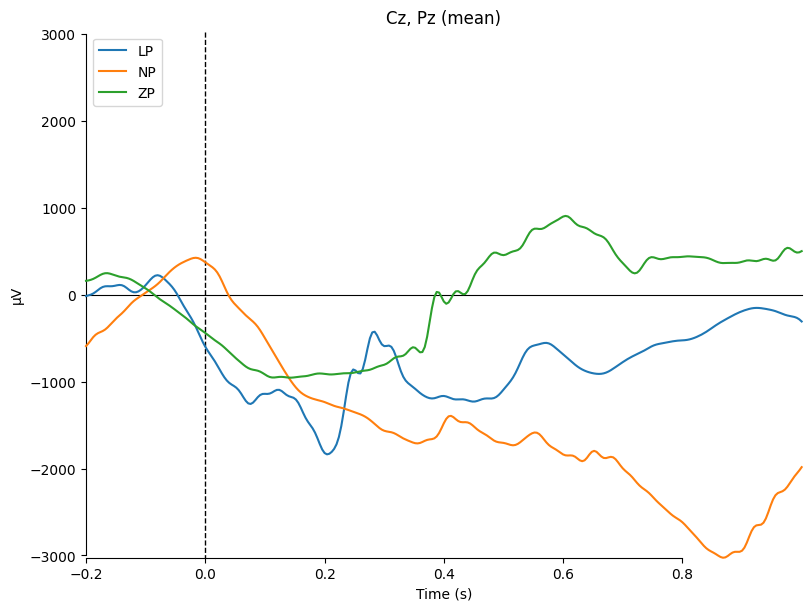

In [102]:
# Show data for Cz, Pz
mne.viz.plot_compare_evokeds(
    {"LP": epochs['lp'].average(),
     "NP": epochs['np'].average(),
     "ZP": epochs['zp'].average()},
    picks=['Cz', 'Pz'],
    combine='mean',
    show=True
)
plt.show()

/var/folders/g2/378vjvgj0vq1r9_l6pb_nbz00000gn/T/ipykernel_16306/1540213811.py:2: RuntimeWarning: Cannot find channel coordinates in the supplied Evokeds. Not showing channel locations.
  mne.viz.plot_compare_evokeds(


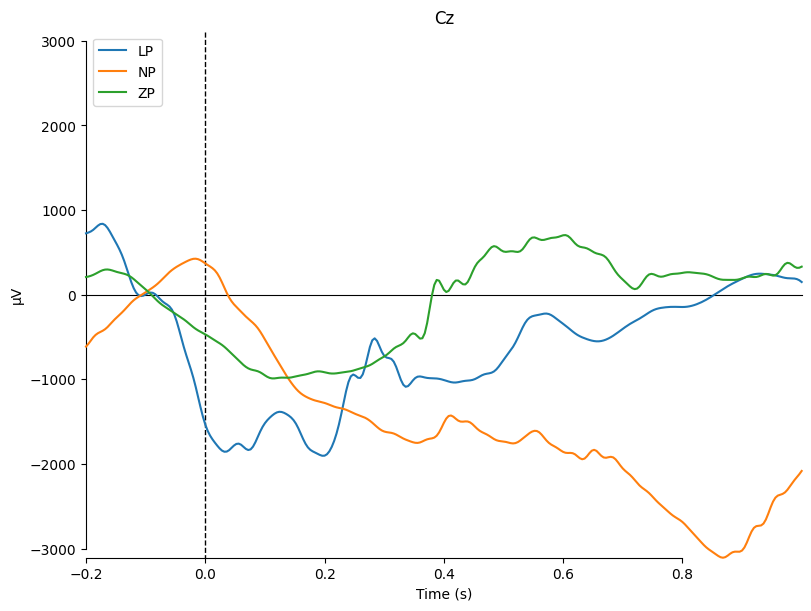

In [103]:
# Show data for Cz
mne.viz.plot_compare_evokeds(
    {"LP": epochs['lp'].average(),
     "NP": epochs['np'].average(),
     "ZP": epochs['zp'].average()},
    picks=['Cz'],
    show=True
)
plt.show()

/var/folders/g2/378vjvgj0vq1r9_l6pb_nbz00000gn/T/ipykernel_16306/2137027528.py:2: RuntimeWarning: Cannot find channel coordinates in the supplied Evokeds. Not showing channel locations.
  mne.viz.plot_compare_evokeds(


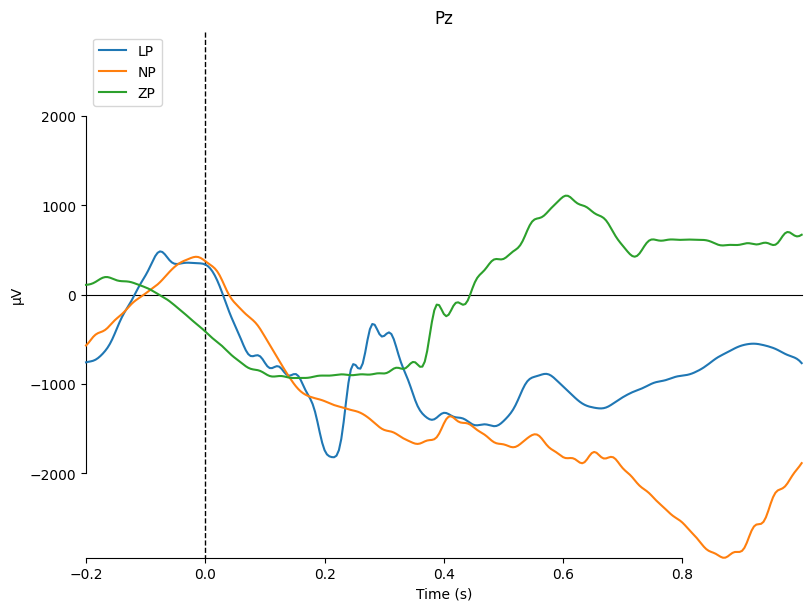

In [104]:
# Show data for Pz
mne.viz.plot_compare_evokeds(
    {"LP": epochs['lp'].average(),
     "NP": epochs['np'].average(),
     "ZP": epochs['zp'].average()},
    picks=['Pz'],
    show=True
)
plt.show()

In [105]:
# Now we can proceed to calculate mean ERPs amplitudes of LPP for the given subject in 400-600 ms time window
tmin, tmax = 0.4, 0.6
lp_amp = epochs['lp'].average().copy().crop(tmin, tmax).get_data().mean(axis=1)  # Across each channel
np_amp = epochs['np'].average().copy().crop(tmin, tmax).get_data().mean(axis=1)
zp_amp = epochs['zp'].average().copy().crop(tmin, tmax).get_data().mean(axis=1)
lp_amp, np_amp, zp_amp  # Channels: Cz, Pz

(array([-0.00067255, -0.00122979]),
 array([-0.00164619, -0.00159016]),
 array([0.00045789, 0.00042967]))

In [133]:
# Instead of averaging across trials, we can assign mean amplitude per trial
cz_amps, pz_amps = np.array(
    [epochs[idx].copy().crop(tmin, tmax).get_data(picks=['Cz', 'Pz'])[0].mean(axis=1) for idx in range(len(epochs))]).T
# Assign computed Cz and Pz amplitudes to the csv_data dataframe
csv_data['Cz_LPP_400_600ms'] = cz_amps
csv_data['Pz_LPP_400_600ms'] = pz_amps
# Print means for each category and check that they are the same as before
print(csv_data.groupby('condition')[['Cz_LPP_400_600ms', 'Pz_LPP_400_600ms']].mean())
csv_data

           Cz_LPP_400_600ms  Pz_LPP_400_600ms
condition                                    
LP                -0.000673          -0.00123
NP                -0.001646          -0.00159
ZP                 0.000458           0.00043


,timestamp_iso,participant_id,age,response_group,trial_index,block,bundle_id,focal_product,tiein_product,condition,...,total_price,allocation_per_trial,response_key,response,rt_ms,valid_response,is_selected_bundle,bundles_bought_cumulative,Cz_LPP_400_600ms,Pz_LPP_400_600ms
0,2026-01-10T09:00:32.793,0,26,A,0,1,45,Doorbell Camera,Chime Unit,NP,...,24.0,70.0,1.0,BUY,1286.14,1,0,1,0.009638,0.009635
1,2026-01-10T09:00:40.402,0,26,A,1,1,3,Camera,Memory Card,ZP,...,28.8,70.0,1.0,BUY,3135.96,1,0,2,0.017979,0.017973
2,2026-01-10T09:00:47.911,0,26,A,2,1,18,Coffee Maker,Coffee Filters,NP,...,19.2,70.0,3.0,NOBUY,1452.70,1,0,2,-0.001341,-0.001341
3,2026-01-10T09:00:55.524,0,26,A,3,1,40,External SSD,Carrying Case,NP,...,22.4,70.0,3.0,NOBUY,1612.21,1,0,2,0.004204,0.004203
4,2026-01-10T09:01:02.982,0,26,A,4,1,6,Gaming Console,Extra Controller,ZP,...,44.0,70.0,1.0,BUY,809.81,1,1,3,-0.001276,-0.001276
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
130,2026-01-10T09:17:03.862,0,26,A,130,3,16,Electric Toothbrush,Brush Heads,NP,...,10.4,70.0,NaN,NaN,NaN,0,0,11,-0.000027,0.000003
131,2026-01-10T09:17:11.455,0,26,A,131,3,38,Printer,Ink Cartridge,NP,...,28.8,70.0,NaN,NaN,NaN,0,0,11,-0.000046,0.000007
132,2026-01-10T09:17:18.965,0,26,A,132,3,34,Mouse,Mouse Pad,NP,...,11.2,70.0,NaN,NaN,NaN,0,0,11,0.000042,-0.000004
133,2026-01-10T09:17:26.460,0,26,A,133,3,44,Security Camera,SD Card,LP,...,25.7,70.0,NaN,NaN,NaN,0,0,11,0.000019,0.000003


In [149]:
['BUY', 'NOBUY', 'BUY'].count('BUY')

2

In [153]:
# For all valid responses, for each condition, calculate: mean LPP amplitudes, response times, purchase rates, total spent
csv_data[csv_data['valid_response'] == 1].groupby('condition').agg(
    mean_Cz_LPP_400_600ms=('Cz_LPP_400_600ms', 'mean'),
    mean_Pz_LPP_400_600ms=('Pz_LPP_400_600ms', 'mean'),
    mean_response_time_ms=('rt_ms', 'mean'),
    total_spent=('total_price', 'sum'),
    mean_spent=('total_price', 'mean'),
    total_trials=('response', 'count'),
    total_bought=('response', lambda x: list(x).count('BUY')),
    purchase_rate=('response', lambda x: list(x).count('BUY') / len(x) * 100)
)

,mean_Cz_LPP_400_600ms,mean_Pz_LPP_400_600ms,mean_response_time_ms,total_spent,mean_spent,total_trials,total_bought,buy_rate
condition,,,,,,,,
LP,-0.000092,-0.000092,2701.3950,35.4,17.70,2,1,50.0
NP,0.001160,0.001159,1774.9075,222.4,27.80,8,6,75.0
ZP,0.002999,0.002998,2462.7260,164.8,32.96,5,4,80.0
